In [1]:
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

2024-07-30 12:53:21.429465: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-30 12:53:21.556222: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-30 12:53:21.559080: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-30 12:53:24.048169: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Directory paths
DATA_DIR = 'Dataset'

In [3]:
def createdataframe(dir):
    image_paths = []
    labels = []
    for label in ['georges', 'no_georges']:  # Explicitly list the folder names
        label_path = os.path.join(dir, label)
        if not os.path.exists(label_path):
            print(f"Directory {label_path} does not exist.")
            continue
        for imagename in os.listdir(label_path):
            image_paths.append(os.path.join(label_path, imagename))
            labels.append(label)
        print(label, "completed")
    return image_paths, labels


In [4]:
# Create a single DataFrame for all data
all_images, all_labels = createdataframe(DATA_DIR)
all_data = pd.DataFrame({'image': all_images, 'label': all_labels})


georges completed
no_georges completed


In [5]:
# Ensure the dataset is stratified when split
train_data, test_data = train_test_split(all_data, test_size=0.2, random_state=42, stratify=all_data['label'])

In [6]:
# Check the shapes of the DataFrames
print(f"Train DataFrame shape: {train_data.shape}")
print(f"Test DataFrame shape: {test_data.shape}")

Train DataFrame shape: (4837, 2)
Test DataFrame shape: (1210, 2)


In [7]:
# Check the count of each unique label in the training and testing sets to ensure stratification
print("\nTraining set label distribution:")
print(train_data['label'].value_counts())

print("\nTesting set label distribution:")
print(test_data['label'].value_counts())


Training set label distribution:
label
no_georges    2692
georges       2145
Name: count, dtype: int64

Testing set label distribution:
label
no_georges    674
georges       536
Name: count, dtype: int64


In [8]:
# Feature extraction
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale', target_size=(48, 48))
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)
    return features


In [9]:
# Extract features for training and testing datasets
train_features = extract_features(train_data['image'])
test_features = extract_features(test_data['image'])

# Normalize the features
x_train = train_features / 255.0
x_test = test_features / 255.0


  0%|          | 0/4837 [00:00<?, ?it/s]

  0%|          | 0/1210 [00:00<?, ?it/s]

In [10]:
# Label encoding
le = LabelEncoder()
le.fit(train_data['label'])
y_train = le.transform(train_data['label'])
y_test = le.transform(test_data['label'])

# One-hot encode the labels
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)


In [11]:
# Print shapes to verify
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (4837, 48, 48, 1)
y_train shape: (4837, 2)
x_test shape: (1210, 48, 48, 1)
y_test shape: (1210, 2)


In [18]:
# Define the model
model = Sequential()

# First Conv layer with 128 filters, kernel size 3x3, and ReLU activation
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# Second Conv layer with 256 filters, kernel size 3x3, and ReLU activation
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# Third Conv layer with 512 filters, kernel size 3x3, and ReLU activation
model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# Fourth Conv layer with 512 filters, kernel size 3x3, and ReLU activation
model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# Flatten the output from the Conv layers
model.add(Flatten())

# Dense layer with 512 units and ReLU activation
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))

# Dense layer with 256 units and ReLU activation
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

# Output layer with 2 units (for binary classification) and softmax activation
model.add(Dense(2, activation='softmax'))


In [19]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 46, 46, 128)       1280      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 23, 23, 128)       0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 23, 23, 128)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 21, 21, 256)       295168    
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 10, 10, 256)       0         
 g2D)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 10, 10, 256)      

In [21]:
# Fit the model
history = model.fit(x=x_train, y=y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test))


Epoch 1/100
48/48 [==============================] - 6s 73ms/step - loss: 0.6857 - accuracy: 0.5527 - val_loss: 0.6733 - val_accuracy: 0.5689
Epoch 2/100
48/48 [==============================] - 3s 63ms/step - loss: 0.6391 - accuracy: 0.6163 - val_loss: 0.6354 - val_accuracy: 0.6370
Epoch 3/100
48/48 [==============================] - 3s 59ms/step - loss: 0.6251 - accuracy: 0.6557 - val_loss: 0.6651 - val_accuracy: 0.5990
Epoch 4/100
48/48 [==============================] - 3s 62ms/step - loss: 0.5870 - accuracy: 0.6893 - val_loss: 0.5653 - val_accuracy: 0.7346
Epoch 5/100
48/48 [==============================] - 3s 59ms/step - loss: 0.5487 - accuracy: 0.7205 - val_loss: 0.5913 - val_accuracy: 0.6840
Epoch 6/100
48/48 [==============================] - 3s 63ms/step - loss: 0.5321 - accuracy: 0.7278 - val_loss: 0.5502 - val_accuracy: 0.7266
Epoch 7/100
48/48 [==============================] - 4s 76ms/step - loss: 0.5263 - accuracy: 0.7432 - val_loss: 0.4836 - val_accuracy: 0.7690
Epoch 

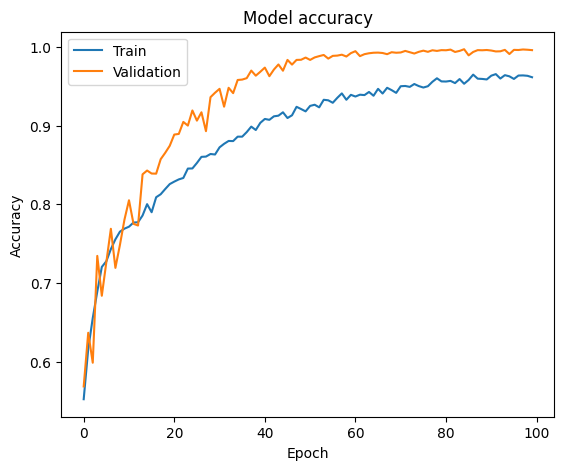

In [22]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

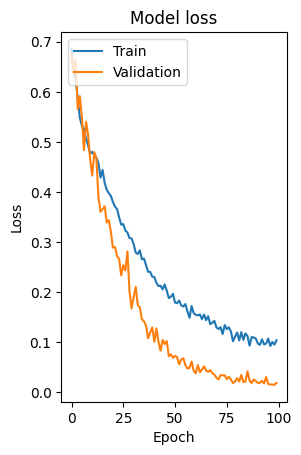

In [23]:

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [26]:
# Predict on the test set
y_pred_prob = model.predict(x_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Convert y_test to class labels
y_test_labels = np.argmax(y_test, axis=1)

# Generate classification report
report = classification_report(y_test_labels, y_pred, target_names=le.classes_)
print(report)

189/189 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

     georges       0.99      1.00      1.00      2681
  no_georges       1.00      0.99      1.00      3366

    accuracy                           1.00      6047
   macro avg       1.00      1.00      1.00      6047
weighted avg       1.00      1.00      1.00      6047



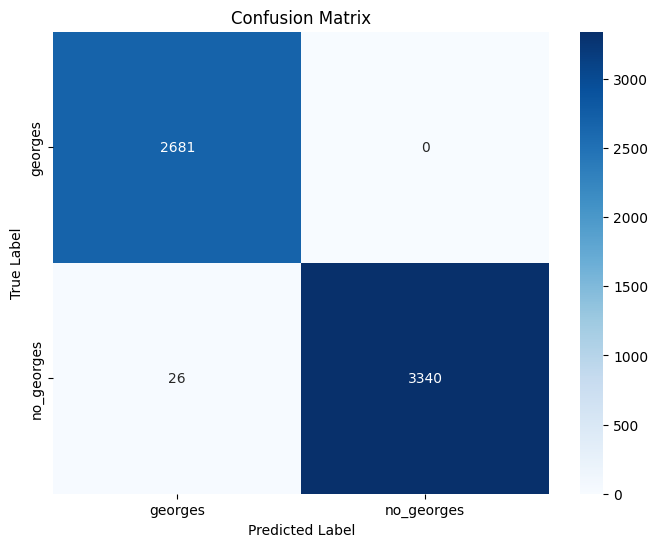

In [29]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [31]:
# Save the entire model (architecture + weights)
model.save("models/st_george_detector.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
